In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import warnings
import matplotlib.pyplot as plt
import seaborn as sns


Filter out all warnings

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)

Read in the csv file and take a look at it

In [3]:
df = pd.read_csv('Dataset_Uber Traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


DateTime feature is in object datatype. Lets change that to its desired time datetime datatype

In [5]:
df['DateTime'] = pd.to_datetime(df.DateTime, format='%d/%m/%y %H:%M')

df.head(10)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


The datatype has been changed. The ID column has no value so lets remove it

In [7]:
df = df.drop(columns='ID')
df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


The data has been cleaned successfully.

Are there duplicated values? If so, lets remove the duplicates

In [8]:
df[['DateTime', 'Junction']].duplicated().sum()

0

In [9]:
df.duplicated().sum()

0

There are no duplicated records. How about records with missing values?

In [10]:
df.isna().sum()

DateTime    0
Junction    0
Vehicles    0
dtype: int64

There are no missing values either. The data has no duplicates nor missing values in any column. We can proceed with our EDA

Before aggregating, lets ensure the data is compiled into hourly intervals. 

Lets sort the data by date and time

In [11]:
df.sort_values('DateTime').reset_index(drop=True).head(10)

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 00:00:00,2,6
2,2015-11-01 00:00:00,3,9
3,2015-11-01 01:00:00,3,7
4,2015-11-01 01:00:00,1,13
5,2015-11-01 01:00:00,2,6
6,2015-11-01 02:00:00,2,5
7,2015-11-01 02:00:00,1,10
8,2015-11-01 02:00:00,3,5
9,2015-11-01 03:00:00,2,6


Wait a minute, there is no data for junction 4 in the first 10 records, From 2015-01-11 00:00:00 to 2015-01-11 03:00:00. 

Lets dive a little bit into that first. Lets find if all junctions have the same amount of data.

In [12]:
df.Junction.value_counts()

Junction
1    14592
2    14592
3    14592
4     4344
Name: count, dtype: int64

Junction 4 has about 10,000 less records as compared to the other junctions. Lets check Junction 4's data

In [13]:
df[df.Junction == 4]

,DateTime,Junction,Vehicles
43776,2017-01-01 00:00:00,4,3
43777,2017-01-01 01:00:00,4,1
43778,2017-01-01 02:00:00,4,4
43779,2017-01-01 03:00:00,4,4
43780,2017-01-01 04:00:00,4,2
...,...,...,...
48115,2017-06-30 19:00:00,4,11
48116,2017-06-30 20:00:00,4,30
48117,2017-06-30 21:00:00,4,16
48118,2017-06-30 22:00:00,4,22


This is indeed True. Junction 4 has records from 2017-01-01 00:00:00, while the other junctions have data from 2015. Lets create new records for 4 for the preceding years and impute the data with 0 

In [14]:
full_index = pd.MultiIndex.from_product(
    [df['DateTime'].unique(), df['Junction'].unique()],
    names=['DateTime', 'Junction']
)
df = df.set_index(['DateTime', 'Junction']).reindex(full_index, fill_value=0).reset_index()

df.head(10)

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 00:00:00,2,6
2,2015-11-01 00:00:00,3,9
3,2015-11-01 00:00:00,4,0
4,2015-11-01 01:00:00,1,13
5,2015-11-01 01:00:00,2,6
6,2015-11-01 01:00:00,3,7
7,2015-11-01 01:00:00,4,0
8,2015-11-01 02:00:00,1,10
9,2015-11-01 02:00:00,2,5


New records were created for junction 4, with 0 traffic. Lets check the new data.

In [15]:
df.Junction.value_counts()

Junction
1    14592
2    14592
3    14592
4    14592
Name: count, dtype: int64

Now all junctions have data. Lets aggregate the data is in hourly interval for all the junctions.

In [16]:
df =  df.groupby(['DateTime', 'Junction'], as_index=False).sum()
df = df.sort_values(['DateTime', 'Junction']).reset_index(drop=True)

df

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 00:00:00,2,6
2,2015-11-01 00:00:00,3,9
3,2015-11-01 00:00:00,4,0
4,2015-11-01 01:00:00,1,13
...,...,...,...
58363,2017-06-30 22:00:00,4,22
58364,2017-06-30 23:00:00,1,78
58365,2017-06-30 23:00:00,2,27
58366,2017-06-30 23:00:00,3,39


Lets standardize the data using the Min-Max Normalization. This scales the data to a fixed range, typically 0 to 1

In [17]:
scaler = MinMaxScaler()
df['Vehicles'] = scaler.fit_transform(df[['Vehicles']])

df

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,0.083333
1,2015-11-01 00:00:00,2,0.033333
2,2015-11-01 00:00:00,3,0.050000
3,2015-11-01 00:00:00,4,0.000000
4,2015-11-01 01:00:00,1,0.072222
...,...,...,...
58363,2017-06-30 22:00:00,4,0.122222
58364,2017-06-30 23:00:00,1,0.433333
58365,2017-06-30 23:00:00,2,0.150000
58366,2017-06-30 23:00:00,3,0.216667


#### Feature Engineering and Selection

Lets generate time-based features such as hour of the day, day of the week, and month.

In [18]:
# Generate time-based features
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Month'] = df['DateTime'].dt.month

df

,DateTime,Junction,Vehicles,Hour,DayOfWeek,Month
0,2015-11-01 00:00:00,1,0.083333,0,6,11
1,2015-11-01 00:00:00,2,0.033333,0,6,11
2,2015-11-01 00:00:00,3,0.050000,0,6,11
3,2015-11-01 00:00:00,4,0.000000,0,6,11
4,2015-11-01 01:00:00,1,0.072222,1,6,11
...,...,...,...,...,...,...
58363,2017-06-30 22:00:00,4,0.122222,22,4,6
58364,2017-06-30 23:00:00,1,0.433333,23,4,6
58365,2017-06-30 23:00:00,2,0.150000,23,4,6
58366,2017-06-30 23:00:00,3,0.216667,23,4,6


Lets create binary indicators for weekends

In [19]:
df['IsWeekend'] = df['DateTime'].dt.dayofweek >= 5
df.head()

,DateTime,Junction,Vehicles,Hour,DayOfWeek,Month,IsWeekend
0,2015-11-01 00:00:00,1,0.083333,0,6,11,True
1,2015-11-01 00:00:00,2,0.033333,0,6,11,True
2,2015-11-01 00:00:00,3,0.050000,0,6,11,True
3,2015-11-01 00:00:00,4,0.000000,0,6,11,True
4,2015-11-01 01:00:00,1,0.072222,1,6,11,True


Lets create lag features for vehicles in the:
- previous hour
- previous 2 hours
- previous 3 hours
- previous 4 hours
- previous 5 hours
- previous 6 hours
- previous 12 hours
- and same time the previous day

In [20]:
df['Vehicles_previous_hour'] = df.groupby('Junction')['Vehicles'].shift(1).fillna(0)
df['Vehicles_previous_2hours'] = df.groupby('Junction')['Vehicles'].shift(2).fillna(0)
df['Vehicles_previous_3hours'] = df.groupby('Junction')['Vehicles'].shift(3).fillna(0)
df['Vehicles_previous_4hours'] = df.groupby('Junction')['Vehicles'].shift(4).fillna(0)
df['Vehicles_previous_5hours'] = df.groupby('Junction')['Vehicles'].shift(5).fillna(0)
df['Vehicles_previous_6hours'] = df.groupby('Junction')['Vehicles'].shift(6).fillna(0)
df['Vehicles_previous_12hours'] = df.groupby('Junction')['Vehicles'].shift(12).fillna(0)
df['Vehicles_previous_day'] = df.groupby('Junction')['Vehicles'].shift(24).fillna(0)
df.head(5)

,DateTime,Junction,Vehicles,Hour,DayOfWeek,Month,IsWeekend,Vehicles_previous_hour,Vehicles_previous_2hours,Vehicles_previous_3hours,Vehicles_previous_4hours,Vehicles_previous_5hours,Vehicles_previous_6hours,Vehicles_previous_12hours,Vehicles_previous_day
0,2015-11-01 00:00:00,1,0.083333,0,6,11,True,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-11-01 00:00:00,2,0.033333,0,6,11,True,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-11-01 00:00:00,3,0.050000,0,6,11,True,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-11-01 00:00:00,4,0.000000,0,6,11,True,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-11-01 01:00:00,1,0.072222,1,6,11,True,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets standardize these new features too.

In [21]:
df['Vehicles_previous_hour'] = scaler.fit_transform(df[['Vehicles_previous_hour']])
df['Vehicles_previous_2hours'] = scaler.fit_transform(df[['Vehicles_previous_2hours']])
df['Vehicles_previous_3hours'] = scaler.fit_transform(df[['Vehicles_previous_3hours']])
df['Vehicles_previous_4hours'] = scaler.fit_transform(df[['Vehicles_previous_4hours']])
df['Vehicles_previous_5hours'] = scaler.fit_transform(df[['Vehicles_previous_5hours']])
df['Vehicles_previous_6hours'] = scaler.fit_transform(df[['Vehicles_previous_6hours']])
df['Vehicles_previous_12hours'] = scaler.fit_transform(df[['Vehicles_previous_12hours']])
df['Vehicles_previous_day'] = scaler.fit_transform(df[['Vehicles_previous_day']])

df.head(10)

,DateTime,Junction,Vehicles,Hour,DayOfWeek,Month,IsWeekend,Vehicles_previous_hour,Vehicles_previous_2hours,Vehicles_previous_3hours,Vehicles_previous_4hours,Vehicles_previous_5hours,Vehicles_previous_6hours,Vehicles_previous_12hours,Vehicles_previous_day
0,2015-11-01 00:00:00,1,0.083333,0,6,11,True,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-11-01 00:00:00,2,0.033333,0,6,11,True,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-11-01 00:00:00,3,0.050000,0,6,11,True,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-11-01 00:00:00,4,0.000000,0,6,11,True,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-11-01 01:00:00,1,0.072222,1,6,11,True,0.083333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,2015-11-01 01:00:00,2,0.033333,1,6,11,True,0.033333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,2015-11-01 01:00:00,3,0.038889,1,6,11,True,0.050000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,2015-11-01 01:00:00,4,0.000000,1,6,11,True,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,2015-11-01 02:00:00,1,0.055556,2,6,11,True,0.072222,0.083333,0.0,0.0,0.0,0.0,0.0,0.0
9,2015-11-01 02:00:00,2,0.027778,2,6,11,True,0.033333,0.033333,0.0,0.0,0.0,0.0,0.0,0.0


Let us check the linear relationships between the features and the target variable, Vehicles, using a correlation analysis

In [22]:
correlation_matrix = df.corr().abs().round(2)

correlation_matrix

,DateTime,Junction,Vehicles,Hour,DayOfWeek,Month,IsWeekend,Vehicles_previous_hour,Vehicles_previous_2hours,Vehicles_previous_3hours,Vehicles_previous_4hours,Vehicles_previous_5hours,Vehicles_previous_6hours,Vehicles_previous_12hours,Vehicles_previous_day
DateTime,1.00,0.0,0.32,0.00,0.00,0.13,0.00,0.32,0.32,0.32,0.32,0.32,0.32,0.32,0.32
Junction,0.00,1.0,0.70,0.00,0.00,0.00,0.00,0.70,0.70,0.70,0.70,0.70,0.70,0.70,0.70
Vehicles,0.32,0.7,1.00,0.18,0.10,0.08,0.12,0.98,0.95,0.92,0.89,0.85,0.82,0.74,0.92
Hour,0.00,0.0,0.18,1.00,0.00,0.00,0.00,0.17,0.14,0.11,0.07,0.03,0.00,0.15,0.18
DayOfWeek,0.00,0.0,0.10,0.00,1.00,0.00,0.79,0.10,0.10,0.09,0.09,0.08,0.08,0.03,0.00
Month,0.13,0.0,0.08,0.00,0.00,1.00,0.01,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.07
IsWeekend,0.00,0.0,0.12,0.00,0.79,0.01,1.00,0.12,0.12,0.12,0.12,0.11,0.11,0.08,0.05
Vehicles_previous_hour,0.32,0.7,0.98,0.17,0.10,0.08,0.12,1.00,0.98,0.95,0.92,0.89,0.85,0.75,0.91
Vehicles_previous_2hours,0.32,0.7,0.95,0.14,0.10,0.08,0.12,0.98,1.00,0.98,0.95,0.92,0.89,0.75,0.90
Vehicles_previous_3hours,0.32,0.7,0.92,0.11,0.09,0.08,0.12,0.95,0.98,1.00,0.98,0.95,0.92,0.76,0.87


Lets plot a heatmap to visualize the correlations

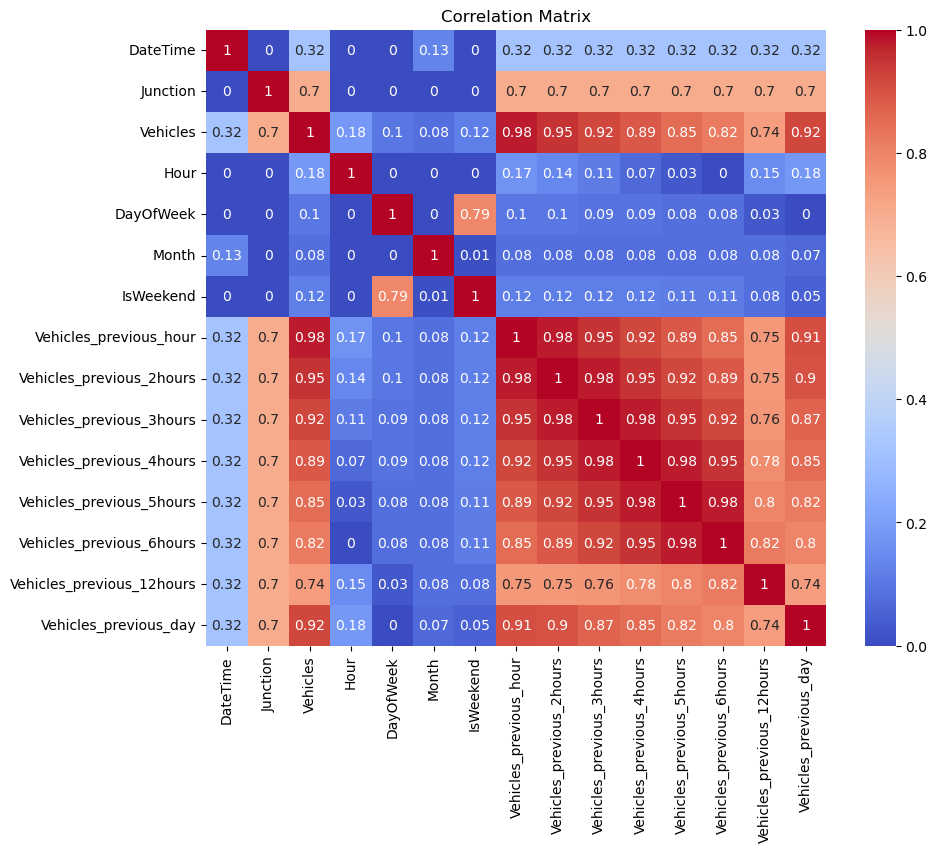

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Lets rank the features and identify some insights

In [24]:
correlation_matrix['Vehicles'].abs().sort_values(ascending=False)


Vehicles                     1.00
Vehicles_previous_hour       0.98
Vehicles_previous_2hours     0.95
Vehicles_previous_3hours     0.92
Vehicles_previous_day        0.92
Vehicles_previous_4hours     0.89
Vehicles_previous_5hours     0.85
Vehicles_previous_6hours     0.82
Vehicles_previous_12hours    0.74
Junction                     0.70
DateTime                     0.32
Hour                         0.18
IsWeekend                    0.12
DayOfWeek                    0.10
Month                        0.08
Name: Vehicles, dtype: float64

The number of vehicles at the junction in the previous hours, as well as the number of vehicles at the same hour in the previous day have the strongest correlation with the number of vehicles at the junction. The month has the least correlation with the number of vehicles in the junction, as well as the hour, day of week and whether it is a weekend or not.

Lets asses feature importance using a RandomForestRegressor model

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Select relevant features
features = ['Junction', 'Hour', 'DayOfWeek', 'Month',
       'IsWeekend', 'Vehicles_previous_hour', 'Vehicles_previous_2hours',
       'Vehicles_previous_3hours', 'Vehicles_previous_4hours',
       'Vehicles_previous_5hours', 'Vehicles_previous_6hours',
       'Vehicles_previous_12hours', 'Vehicles_previous_day']
X = df[features]
y = df['Vehicles']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Get feature importances and their absolute values

In [26]:
importances = model.feature_importances_
abs_importances = np.abs(importances)
indices = np.argsort(abs_importances)[::-1]

print("Feature ranking with absolute importance:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {features[indices[f]]} ({abs_importances[indices[f]]})")


Feature ranking with absolute importance:
1. feature Vehicles_previous_hour (0.951113381936689)
2. feature Vehicles_previous_day (0.010100623073513062)
3. feature Hour (0.009966417824748913)
4. feature Vehicles_previous_2hours (0.00536163108180708)
5. feature Vehicles_previous_12hours (0.0041638232443789265)
6. feature Vehicles_previous_3hours (0.00390920775218445)
7. feature Vehicles_previous_6hours (0.0032629531789731977)
8. feature Vehicles_previous_4hours (0.0031561446256811146)
9. feature Vehicles_previous_5hours (0.0028855950206934915)
10. feature Month (0.0024485187391664123)
11. feature DayOfWeek (0.0021450029528882844)
12. feature Junction (0.0010599917466942322)
13. feature IsWeekend (0.00042670882258181184)


Using feature importance, we can observe that Day of week, Month, Junction and Isweekend features are the least important. 


We will therefore remove these three features; Day of week, Month and Isweekend features.

In [27]:
df.drop(columns = ['DayOfWeek', 'Month', 'IsWeekend'], inplace = True)
df

,DateTime,Junction,Vehicles,Hour,Vehicles_previous_hour,Vehicles_previous_2hours,Vehicles_previous_3hours,Vehicles_previous_4hours,Vehicles_previous_5hours,Vehicles_previous_6hours,Vehicles_previous_12hours,Vehicles_previous_day
0,2015-11-01 00:00:00,1,0.083333,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2015-11-01 00:00:00,2,0.033333,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2015-11-01 00:00:00,3,0.050000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2015-11-01 00:00:00,4,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2015-11-01 01:00:00,1,0.072222,1,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
58363,2017-06-30 22:00:00,4,0.122222,22,0.088889,0.166667,0.061111,0.094444,0.088889,0.088889,0.083333,0.083333
58364,2017-06-30 23:00:00,1,0.433333,23,0.466667,0.500000,0.533333,0.583333,0.527778,0.500000,0.561111,0.527778
58365,2017-06-30 23:00:00,2,0.150000,23,0.161111,0.172222,0.194444,0.188889,0.188889,0.177778,0.155556,0.200000
58366,2017-06-30 23:00:00,3,0.216667,23,0.144444,0.155556,0.172222,0.183333,0.211111,0.200000,0.155556,0.138889
